In [ ]:
import jax
import fullstream.models as models
from fullstream.cls import cls_maker
import numpy as np
import jax.experimental.stax as stax
import jax.experimental.optimizers as optimizers
import jax.random

In [ ]:
init_random_params, predict = stax.serial(
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(2),
    stax.Softmax,
)

In [ ]:
def get_hists(network, s, b1, b2):
    NMC = len(s)
    LUMI = 10
    #     s, b1, b2 = (
    #         predict(network, s).ravel().sum() * 2 / NMC * LUMI,
    #         predict(network, b1).ravel().sum() * 10 / NMC * LUMI,
    #         predict(network, b2).ravel().sum() * 10 / NMC * LUMI,
    #     )
    sh, bh1, bh2 = (
        predict(network, s).sum(axis=0) * 2 / NMC * LUMI,
        predict(network, b1).sum(axis=0) * 10 / NMC * LUMI,
        predict(network, b2).sum(axis=0) * 10 / NMC * LUMI,
    )
    b_mean = jax.numpy.mean(jax.numpy.asarray([bh1, bh2]), axis=0)
    b_unc = jax.numpy.std(jax.numpy.asarray([bh1, bh2]), axis=0)
    results = sh, b_mean, b_unc
    print(predict(network, s)[0])
    return results


def hist_maker():
    NMC = 500
    bkg1 = np.random.multivariate_normal([2, 2], [[1, 0], [0, 1]], size=(NMC,))
    bkg2 = np.random.multivariate_normal([-1, -1], [[1, 0], [0, 1]], size=(NMC,))
    sig = np.random.multivariate_normal([-1, 1], [[1, 0], [0, 1]], size=(NMC,))

    def make(network):
        return get_hists(network, sig, bkg1, bkg2)

    make.bkg1 = bkg1
    make.bkg2 = bkg2
    make.sig = sig
    return make


def makeNN():
    hm = hist_maker()

    def nn_model_maker(network):
        s, b, db = hm(network)
        # print(f'Model: {s}, {b}, {db}')
        m = models.hepdata_like(s, b, db)
        nompars = m.config.suggested_init()
        bonlypars = jax.numpy.asarray([x for x in nompars])
        bonlypars = jax.ops.index_update(bonlypars, m.config.poi_index, 0.0)
        return m, bonlypars

    nn_model_maker.hm = hm
    return nn_model_maker

In [ ]:
nnm = makeNN()
loss = cls_maker(nnm, solver_kwargs=dict(pdf_transform=True))

In [ ]:
_, network = init_random_params(jax.random.PRNGKey(2), (-1, 2))
jax.value_and_grad(loss)(network, 1.0)

/home/phinate/envs/fullstream/lib/python3.7/site-packages/jax-0.1.58-py3.7.egg/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.


Traced<ConcreteArray([0.50567115 0.49432885])>with<JVPTrace(level=1/0)>
exp_data: Traced<ConcreteArray([[ 49.38902973  50.61097027]
 [849.65549739 892.21847058]])>with<JVPTrace(level=1/0)>
Traced<ShapedArray(float64[2]):JaxprTrace(level=2/0)>
Traced<ShapedArray(float64[2]):JaxprTrace(level=2/0)>
Traced<ConcreteArray([0.50567115 0.49432885])>with<JVPTrace(level=4/0)>


(DeviceArray(0.06582846, dtype=float64),
 [(DeviceArray([[-0.00356681,  0.0054187 , -0.00174301, ..., -0.00469079,
                  0.00056601, -0.0081912 ],
                [-0.00220063,  0.00525155, -0.00354428, ..., -0.00539596,
                  0.00084666, -0.00691498]], dtype=float32),
   DeviceArray([ 0.00258117,  0.00056678,  0.00211738, ...,  0.00457107,
                -0.00066595, -0.00288104], dtype=float32)),
  (),
  (DeviceArray([[-5.59599630e-06, -1.40802193e-04, -1.30117987e-04, ...,
                 -5.77182102e-04,  3.61035404e-06, -1.87780621e-04],
                [ 8.21259819e-05, -3.38403333e-06,  2.95874779e-04, ...,
                  1.49212778e-04, -6.28249563e-06,  6.90855595e-05],
                [ 3.27183045e-07, -9.49730165e-05, -3.31709853e-05, ...,
                 -3.85197141e-04,  1.53300243e-06, -1.21702564e-04],
                ...,
                [-9.89151795e-06, -2.21038295e-04, -2.17841065e-04, ...,
                 -9.03943670e-04,  5.88284001e-

In [ ]:
def train_network(N):
    cls_vals = []
    opt_init, opt_update, opt_params = optimizers.adam(1e-3)
    _, network = init_random_params(jax.random.PRNGKey(1), (-1, 2))
    state = opt_init(network)
    losses = []
    for i in range(N):
        network = opt_params(state)
        value, grad = jax.value_and_grad(loss)(network, 1.0)
        losses.append(value)
        state = opt_update(i, grad, state)
        metrics = {"loss": losses}
        yield network, metrics

In [ ]:
def plot(axarr, network, metrics, hm, maxN):
    ax = axarr[0]
    g = np.mgrid[-5:5:101j, -5:5:101j]
    levels = np.linspace(0, 1, 21)
    ax.contourf(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, 2)[:, :, 0],
        levels=levels,
        cmap="BrBG",
    )
    ax.contour(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, 2)[:, :, 0],
        colors="w",
        levels=levels,
    )
    ax.scatter(hm.sig[:, 0], hm.sig[:, 1], alpha=0.25, c="C9", label="sig")
    ax.scatter(hm.bkg1[:, 0], hm.bkg1[:, 1], alpha=0.17, c="C1", label="bkg1")
    ax.scatter(hm.bkg2[:, 0], hm.bkg2[:, 1], alpha=0.17, c="C1", label="bkg2")
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    ax = axarr[1]
    ax.axhline(0.05,c="slategray",linestyle='--')
    ax.plot(metrics["loss"], c="steelblue", linewidth=2.0)
   
    ax.set_ylim(0, 0.6)
    ax.set_xlim(0, maxN)
    ax.set_xlabel("epoch")
    ax.set_ylabel(r"$cl_s$")

    ax = axarr[2]
    s, b, db = hm(network)
    ax.bar([0, 1], b, color="C1", label="bkg")
    ax.bar([0, 1], s, bottom=b, color="C9", label="sig")
    ax.bar([0, 1], db, bottom=b - db / 2.0, alpha=0.4, color="black", label="bkg error")
    ax.set_ylim(0, 100)
    ax.set_ylabel("frequency")
    ax.set_xlabel("nn output")

Traced<ConcreteArray([0.49364146 0.50635854])>with<JVPTrace(level=1/0)>
exp_data: Traced<ConcreteArray([[ 49.99069848  50.00930152]
 [798.06128106 798.65535647]])>with<JVPTrace(level=1/0)>
Traced<ShapedArray(float64[2]):JaxprTrace(level=2/0)>
Traced<ShapedArray(float64[2]):JaxprTrace(level=2/0)>
Traced<ConcreteArray([0.49364146 0.50635854])>with<JVPTrace(level=4/0)>
epoch 0: CLs = 0.06638949861570853
[0.49364146 0.50635854]
Traced<ConcreteArray([0.55524553 0.44475447])>with<JVPTrace(level=1/0)>
exp_data: Traced<ConcreteArray([[43.68038303 56.31961697]
 [ 3.90445066  6.49092287]])>with<JVPTrace(level=1/0)>
Traced<ShapedArray(float64[2]):JaxprTrace(level=2/0)>
Traced<ShapedArray(float64[2]):JaxprTrace(level=2/0)>
Traced<ConcreteArray([0.55524553 0.44475447])>with<JVPTrace(level=4/0)>
epoch 1: CLs = 0.4673845677501278
[0.55524553 0.44475447]
Traced<ConcreteArray([0.59110411 0.40889589])>with<JVPTrace(level=1/0)>
exp_data: Traced<ConcreteArray([[41.25185575 58.74814425]
 [ 3.67126954  7.44

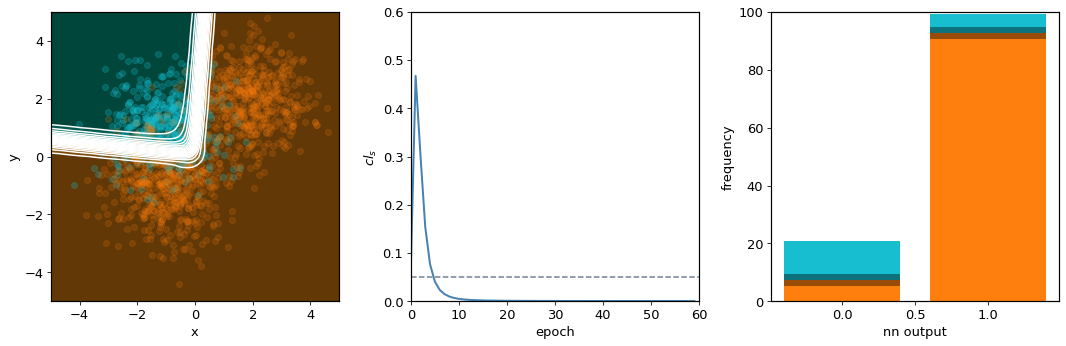

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from celluloid import Camera
from IPython.display import HTML

plt.rcParams.update(
    {
        "axes.labelsize": 13,
        "axes.linewidth": 1.2,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "figure.figsize": [7.2, 3.0],
        "font.size": 13,
        "xtick.major.size": 4,
        "ytick.major.size": 4,
        "legend.fontsize": 11,
    }
)


fig, axarr = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
camera = Camera(fig)
maxN = 60
for i, (network, metrics) in enumerate(train_network(maxN)):
    print(f"epoch {i}:", f'CLs = {metrics["loss"][-1]}')
    plot(axarr, network, metrics, nnm.hm, maxN=maxN)
    plt.tight_layout()
    camera.snap()
    if i % 10 == 0:
        camera.animate().save("animation.gif", writer="imagemagick", fps=8)
        HTML(camera.animate().to_html5_video())
camera.animate().save("animation.gif", writer="imagemagick", fps=8)